In [ ]:
!pip install lightning-bolts --quiet

In [ ]:
!rm -rf S18
!git clone https://github.com/mHemaAP/S18.git

Cloning into 'S18'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 44 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (44/44), 1.63 MiB | 12.67 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
%cd S18/Part2
%ls

/kaggle/working/S18/Part2
S18_VAE_CIFAR10_train.ipynb  data_module/  vae.py
S18_VAE_MNIST_train.ipynb    utils.py


In [ ]:
import random
import numpy as np
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure

from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

from vae import VAE
from data_module.cifar10 import CIFAR10_DataModule

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed a

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
cifar10_data_module = CIFAR10_DataModule()

In [ ]:
pl.seed_everything(56)
model_vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=30)
trainer.fit(model_vae, cifar10_data_module)

100%|██████████| 170498071/170498071 [00:08<00:00, 20972496.80it/s]


Extracting data/cifar-10-python.tar.gz to data


Training: 0it [00:00, ?it/s]

Training loss at end of epoch 0 = 3918.2001953125
Training loss at end of epoch 1 = 3266.4228515625
Training loss at end of epoch 2 = 2895.59375
Training loss at end of epoch 3 = 2644.751220703125
Training loss at end of epoch 4 = 2503.925537109375
Training loss at end of epoch 5 = 2393.404541015625
Training loss at end of epoch 6 = 2317.548583984375
Training loss at end of epoch 7 = 2252.1142578125
Training loss at end of epoch 8 = 2175.414306640625
Training loss at end of epoch 9 = 2121.95703125
Training loss at end of epoch 10 = 2049.4736328125
Training loss at end of epoch 11 = 1983.13232421875
Training loss at end of epoch 12 = 1921.565185546875
Training loss at end of epoch 13 = 1862.1002197265625
Training loss at end of epoch 14 = 1797.6209716796875
Training loss at end of epoch 15 = 1730.53173828125
Training loss at end of epoch 16 = 1672.9852294921875
Training loss at end of epoch 17 = 1621.774169921875
Training loss at end of epoch 18 = 1571.3883056640625
Training loss at end

In [ ]:
test_data = cifar10_data_module.test_dataloader()
# Get the first batch (a batch of images and labels) by break
for batch in test_data:
    images, label_ohe, label_ohe_random= batch
    break

In [ ]:
# Define CIFAR-10 class labels
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# Select one image and its corresponding label OHE
index = random.randint(0, 63)
image = images[index]
label_ohe_correct= label_ohe[index]
label_ohe_incorrect = label_ohe_random[index]

# Get the CIFAR10 labels
label_correct = cifar10_classes[np.argmax(label_ohe_correct)]
label_incorrect = cifar10_classes[np.argmax(label_ohe_incorrect)]

In [ ]:
# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
# PyTorch stores images as (C, H, W), so we transpose it to (H, W, C)
img = image.permute(1, 2, 0).numpy()*std + mean

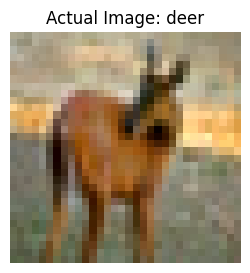

In [ ]:
# PLOT IMAGES
plt.figure(figsize=(3, 3))  # Adjust the size as needed
plt.imshow(img)
plt.title(f"Actual Image: {label_correct}")  # Set the title as the class label
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
image = image.unsqueeze(0)

with torch.no_grad():
    model_vae = model_vae.to('cuda')  # Move the entire model to GPU
    # Now pass this image through VAE encoder and plot the decoder output
    encoded_image = model_vae.encoder(image.to('cuda'))
    combined_features = torch.cat((encoded_image, label_ohe_correct.unsqueeze(0).to('cuda')), dim=1) #get OHE for label features
    mu, log_var = model_vae.fc_mu(combined_features), model_vae.fc_var(combined_features)

    # sample z from q
    std_ = torch.exp(log_var / 2)
    q = torch.distributions.Normal(mu, std_)
    z = q.rsample()

    # decoded
    decoded_image = model_vae.decoder(z).to('cpu')

decoded_img = decoded_image[0].permute(1, 2, 0).numpy()*std + mean

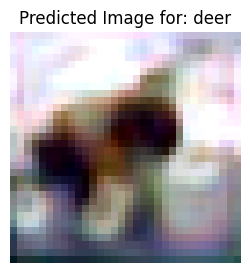

In [ ]:
# Plot the generated image with actual label
plt.figure(figsize=(3, 3))  # Adjust the size as needed
plt.imshow(decoded_img)
plt.axis('off')
plt.title(f"Predicted Image for: {label_correct}")
plt.show()

In [ ]:
decoded_images = []
decoded_images_plot = []
with torch.no_grad():

    for i in range(25):
        if len(decoded_images) == 0:
            image = image
        else:
            image = decoded_images[-1]
        # Now pass this image through VAE encoder and plot the decoder output
        encoded_image = model_vae.encoder(image.to('cuda'))
        combined_features = torch.cat((encoded_image, label_ohe_incorrect.unsqueeze(0).to('cuda')), dim=1) #get OHE for label features
        mu, log_var = model_vae.fc_mu(combined_features), model_vae.fc_var(combined_features)

        # sample z from q
        std_ = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std_)
        z = q.rsample()

        # decoded
        decoded_image = model_vae.decoder(z)
        decoded_images.append(decoded_image)
        decoded_image = decoded_image.to('cpu')
        decoded_images_plot.append(decoded_image[0].permute(1, 2, 0).numpy()*std + mean)


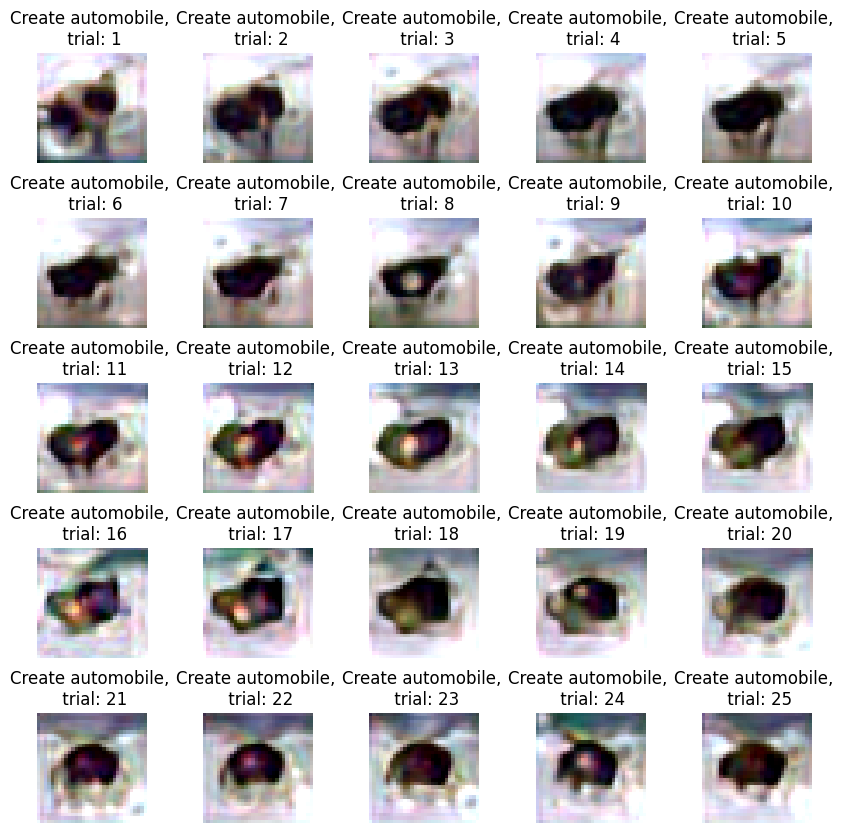

In [ ]:
# Plot the 25 images

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Flatten the axes array so that we can iterate over it easily
axes = axes.flatten()

# Iterate through the images and plot them in the subplots
for i, ax in enumerate(axes):
    ax.imshow(decoded_images_plot[i])  # Replace 'gray' with a colormap of your choice
    ax.set_title(f"Create {label_incorrect}, \n trial: {i+1}")
    ax.axis('off')  # Turn off axis labels and ticks

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Display the plot
plt.show()